Advanced Lane Finding (Project description)

Udacity - Self-Driving Car NanoDegree

In this project, your goal is to write a software pipeline to identify the lane boundaries in a video, but the main output or product we want you to create is a detailed writeup of the project. Check out the writeup template for this project and use it as a starting point for creating your own writeup.
Creating a great writeup:

A great writeup should include the rubric points as well as your description of how you addressed each point. You should include a detailed description of the code used in each step (with line-number references and code snippets where necessary), and links to other supporting documents or external references. You should include images in your writeup to demonstrate how your code works with examples.

All that said, please be concise! We're not looking for you to write a book here, just a brief description of how you passed each rubric point, and references to the relevant code :).

You're not required to use markdown for your writeup. If you use another method please just submit a pdf of your writeup.
The Project

The goals / steps of this project are the following:

    Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    Apply a distortion correction to raw images.
    Use color transforms, gradients, etc., to create a thresholded binary image.
    Apply a perspective transform to rectify binary image ("birds-eye view").
    Detect lane pixels and fit to find the lane boundary.
    Determine the curvature of the lane and vehicle position with respect to center.
    Warp the detected lane boundaries back onto the original image.
    Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

The images for camera calibration are stored in the folder called camera_cal. The images in test_images are for testing your pipeline on single frames. If you want to extract more test images from the videos, you can simply use an image writing method like cv2.imwrite(), i.e., you can read the video in frame by frame as usual, and for frames you want to save for later you can write to an image file.

To help the reviewer examine your work, please save examples of the output from each stage of your pipeline in the folder called ouput_images, and include a description in your writeup for the project of what each image shows. The video called project_video.mp4 is the video your pipeline should work well on.

The challenge_video.mp4 video is an extra (and optional) challenge for you if you want to test your pipeline under somewhat trickier conditions. The harder_challenge.mp4 video is another optional challenge and is brutal!

If you're feeling ambitious (again, totally optional though), don't stop there! We encourage you to go out and take video of your own, calibrate your camera and show us how you would implement this project from scratch!

Import all the libraries that are necessary 

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from PIL import Image
%matplotlib inline

The following is function that read all the camera calibration chess board images and use the OpenCV function to see if it is possible finding all the chess board corners. The default input for column and row are 9 and 6 respectivitly. The default input was selected simply because the chess boards in all the images files are 6 x 9. The function return the object points (3D points in real world space) and the image points (2D points in image plane).

In [7]:
import glob

def getObjAndImgPointsFromChessBoardImages(col = 9, row = 6):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((col*row,3), np.float32)
    objp[:,:2] = np.mgrid[0:col, 0:row].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (col,row), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    return objpoints, imgpoints

I define a function that Undistort an image. The function should take care of the all minor detail such as calibrate a camera. It will read the file calibration.p for the mtx and dist parameters that is needed for the undistort function for OpenCV. If the file is not available, then it will call getObjAndImgPointsFromChessBoardImages function defined above and then call the OpenCV calibrateCamera function

In [8]:
import pickle

def UndistortImage(img):
    img_size = (img.shape[1], img.shape[0])
    
    
    calibratefile = "camera_cal/calibration.p"
    if os.path.isfile(calibratefile):       
        cal_pickle = pickle.load( open(calibratefile, "rb" ) )
        mtx = cal_pickle["mtx"]
        dist = cal_pickle["dist"]
    else:
        objpoints, imgpoints = getObjAndImgPointsFromChessBoardImages()
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)
        cal_pickle = {}
        cal_pickle["mtx"] = mtx
        cal_pickle["dist"] = dist
        pickle.dump( cal_pickle, open( calibratefile, "wb" ) )
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

import os
import ntpath

# Create an output directory in case it does not exist
if not os.path.exists("output_images"):
    os.makedirs("output_images")


Test on a raw image

In [9]:
# Create a function that allow us to display two images in a row for side by side comparsion
def CompareImage(img1, img2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=10)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=10)

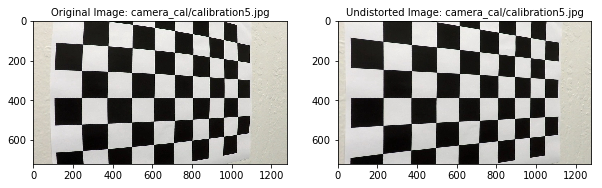

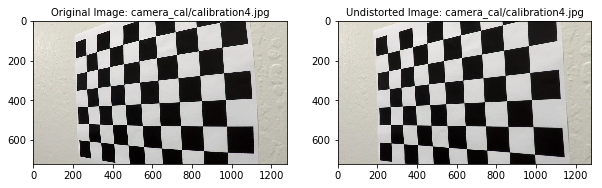

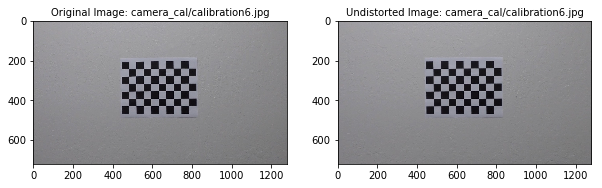

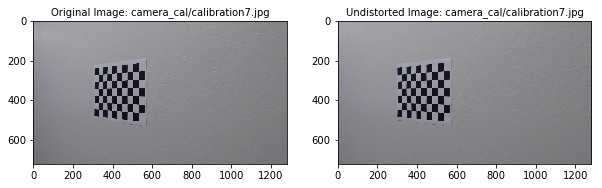

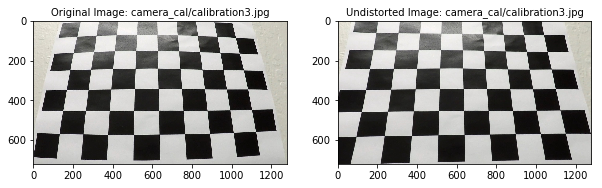

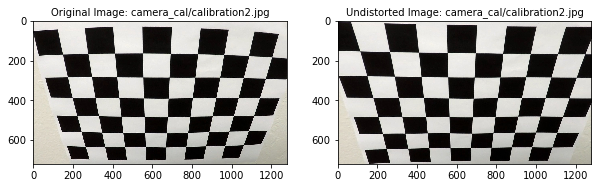

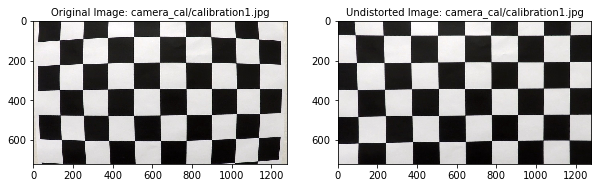

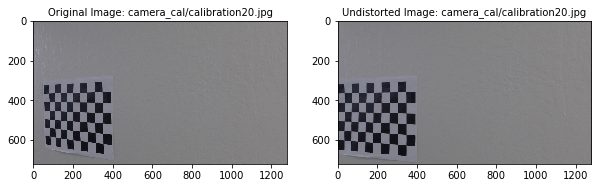

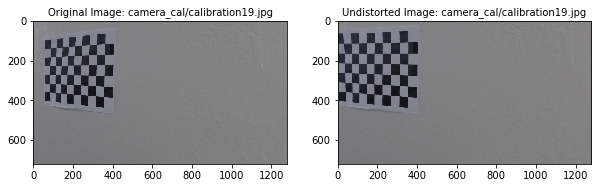

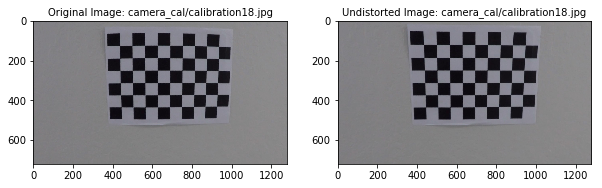

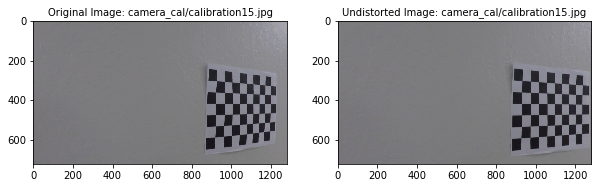

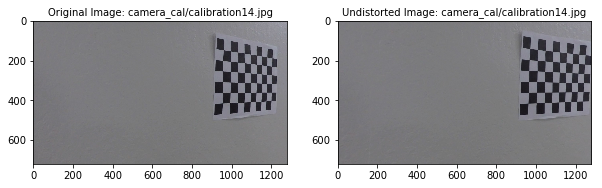

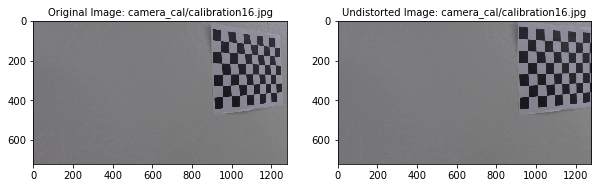

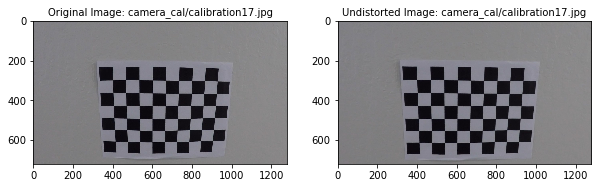

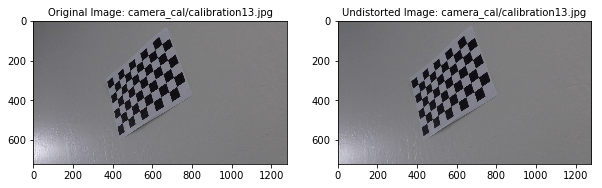

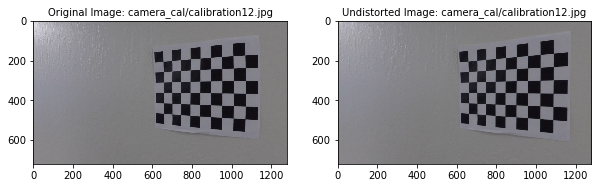

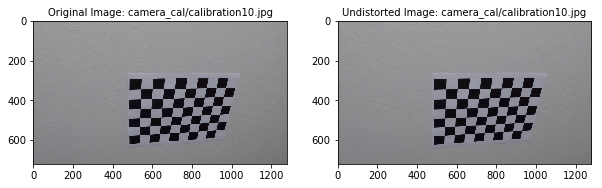

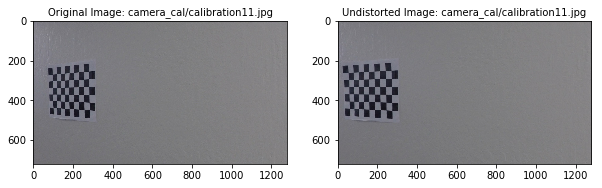

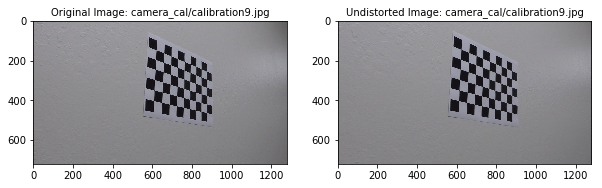

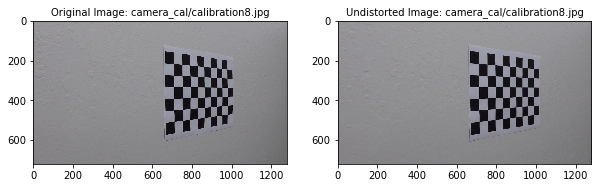

In [10]:
chessboard = glob.glob('camera_cal/calibration*.jpg')
for fname in chessboard:
    img = mpimg.imread(fname)
    dst = UndistortImage(img)
    filename = ntpath.basename(fname)
    im = Image.fromarray(dst)
    im.save("output_images/ChessBoardUndistorted_" + filename)
    CompareImage(img, dst, 'Original Image: '+fname, 'Undistorted Image: '+fname)

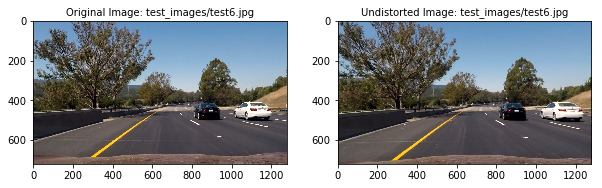

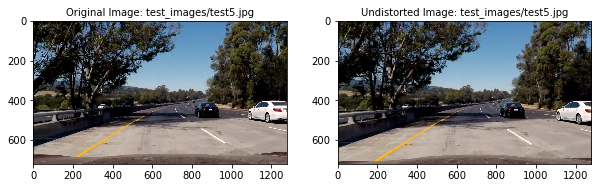

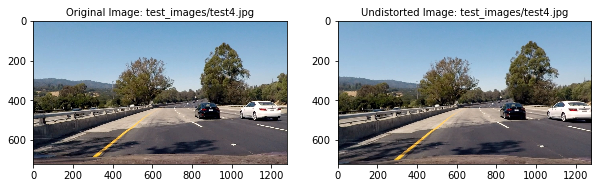

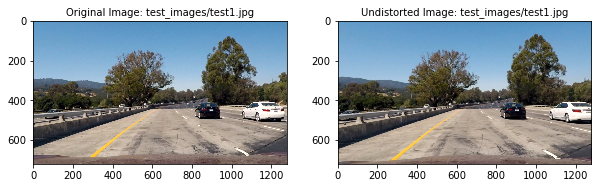

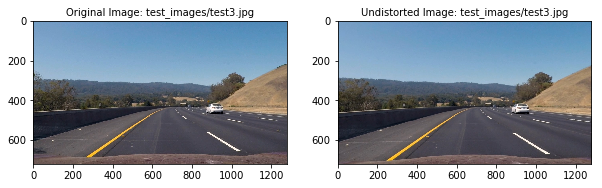

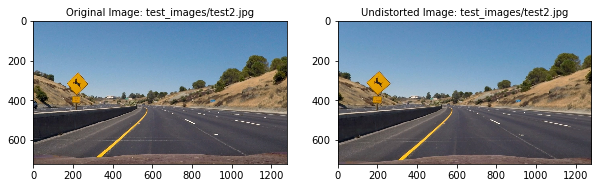

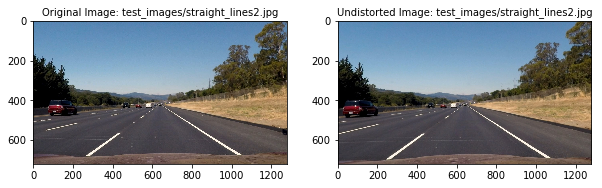

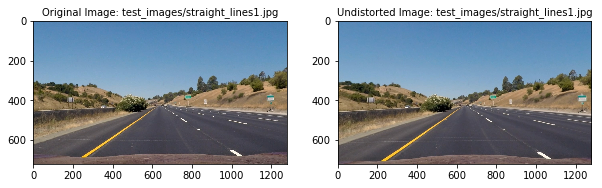

In [11]:
images = glob.glob('test_images/*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    dst = UndistortImage(img)
    filename = ntpath.basename(fname)
    im = Image.fromarray(dst)
    im.save("output_images/undistorted_" + filename)
    CompareImage(img, dst, 'Original Image: '+fname, 'Undistorted Image: '+fname)

Here is the function that obtain the S channel of the HLS color spacing. The default threshold of 120 and 255 were choosen.

In [12]:
def hls_select(img, thresh=(90, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


Here is the function that do X gradient with Sobel Operator on an image. I use only X gradient because I think that X Gradient do a better job for lane detection without adding too much noise.

In [13]:
def X_gradient(img, thresh=(20, 100)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)    
    derivative = cv2.Sobel(gray, cv2.CV_64F, 1, 0)

    abs_derivative = np.absolute(derivative)
    scaled_sobel = np.uint8(255*abs_derivative/np.max(abs_derivative))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return grad_binary

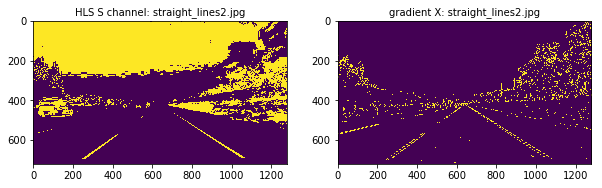

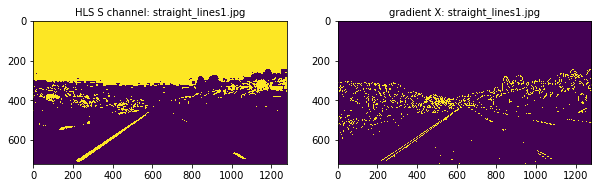

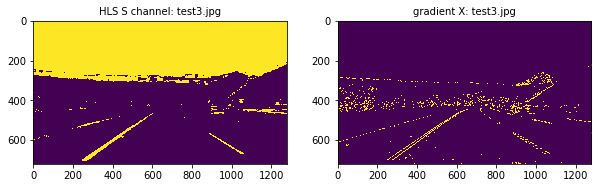

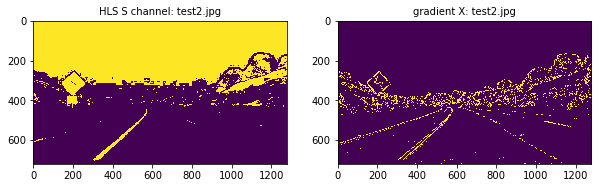

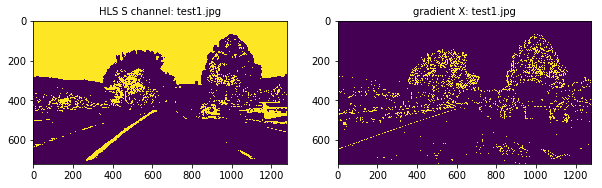

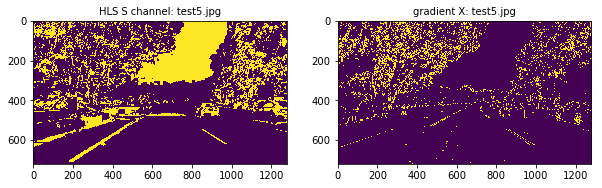

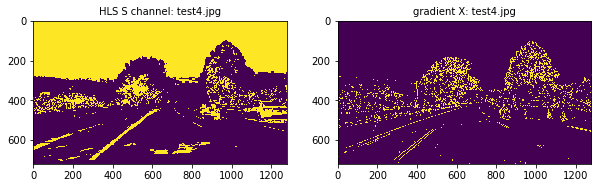

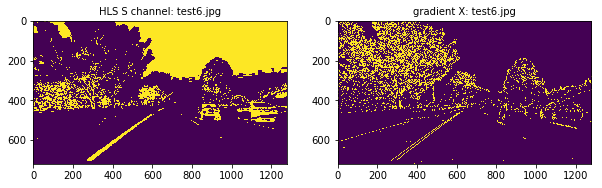

In [14]:
images = glob.glob('output_images/undistorted_*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    gradx = X_gradient(img)
    hls_binary = hls_select(img)
    filename = ntpath.basename(fname)
    cv2.imwrite("output_images/gradX" + filename[12:], gradx*255)
    cv2.imwrite("output_images/HLS_S_Channel_" + filename[12:], hls_binary*255)
    CompareImage(hls_binary, gradx, 'HLS S channel: '+filename[12:], 'gradient X: '+filename[12:])

The following function combine both the HLS and Sobel Operator of X gradient onto an image for lane detection. Now, it is very obvious that combine X gradient along with HLS S channel output give us more detail of the lane line.

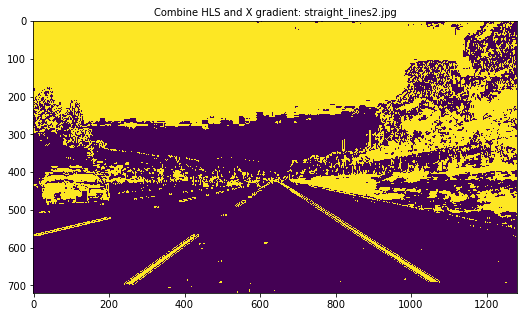

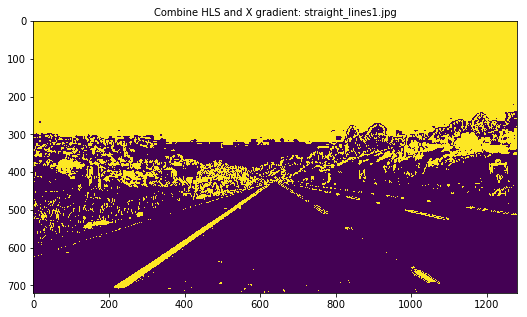

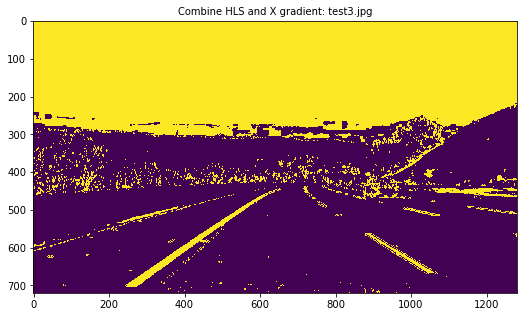

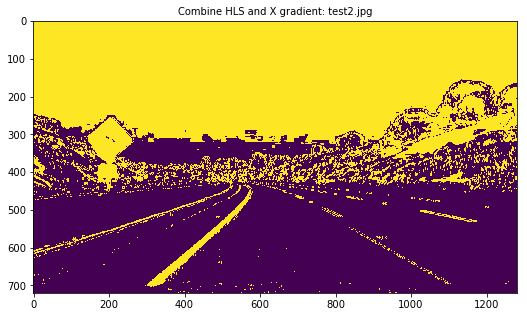

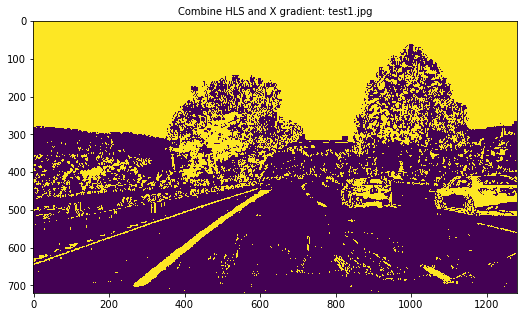

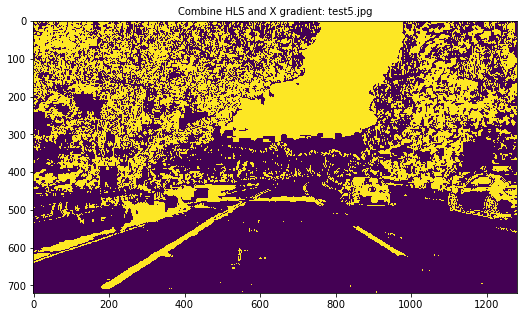

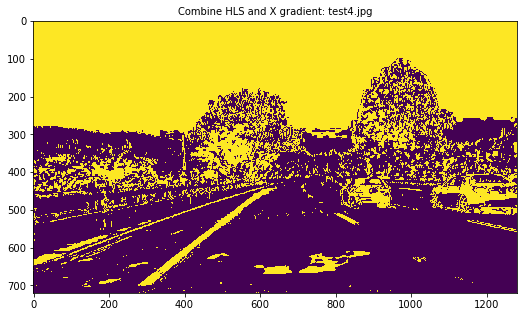

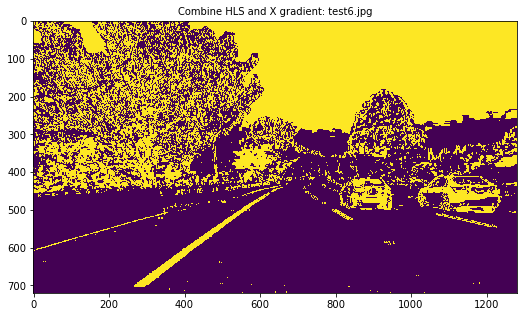

In [15]:
def CombineAllThresholdsAndHLS(img):
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    hls_binary = hls_select(img)
    threshold = X_gradient(img)
    binary_output = np.zeros_like(threshold)
    binary_output[(hls_binary == 1) | (threshold == 1)] = 1    

    return binary_output

images = glob.glob('output_images/undistorted_*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    combine = CombineAllThresholdsAndHLS(img)
    filename = ntpath.basename(fname)
    cv2.imwrite("output_images/combine_HLS_X_Grad_" + filename[12:], gradx*255)
    
    f, (ax1) = plt.subplots(1, 1, figsize=(10,5))
    ax1.imshow(combine)
    ax1.set_title("Combine HLS and X gradient: "+filename[12:], fontsize=10)

A function that called WarpBinaryImg that actually undistort an image, combine the threshold and the HLS S channel of the image, calculate the source and destination points of the perspective, and do perspective transformation, and then warp the image and generate the warped binary image. I simply hard code and keep fine tuning the value of the source and destination points for the OpenCV getPerspectiveTransform function until it is perfect.

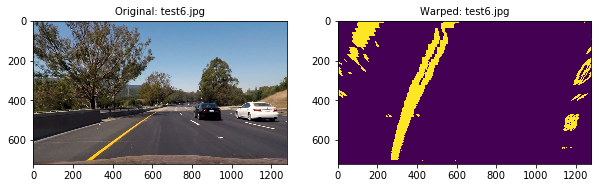

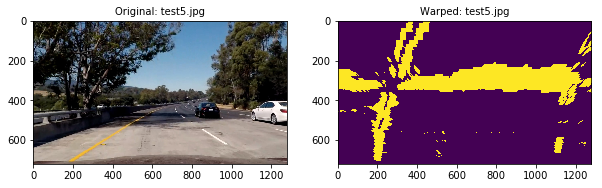

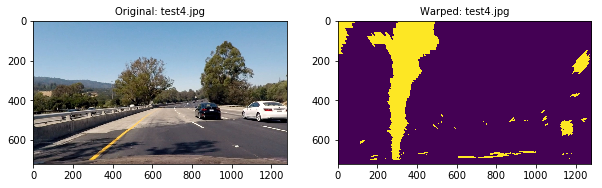

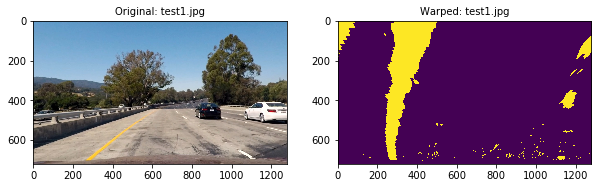

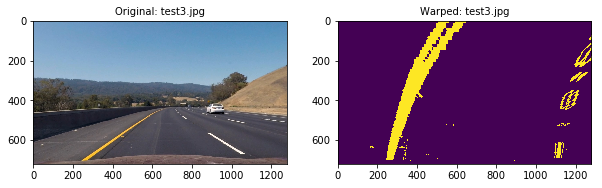

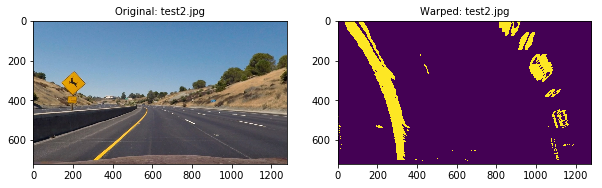

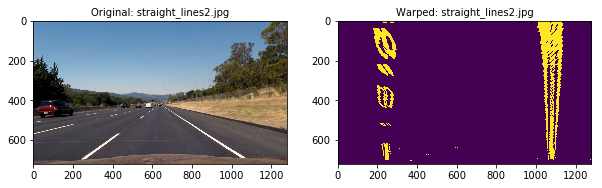

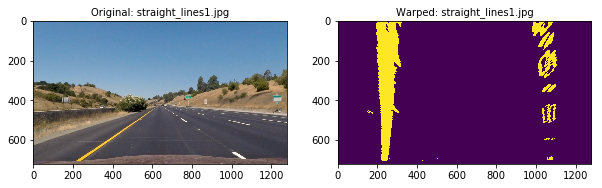

In [16]:
def WarpBinaryImg(img):
    out = CombineAllThresholdsAndHLS(img)
    
    src_p = np.float32([[1043,700],[771,510],[237,700],[509,510]])
    dst_p = np.float32([[1043,700],[1043,510],[237,700],[237,510]])
    
    M = cv2.getPerspectiveTransform(src_p, dst_p)
    M2 = cv2.getPerspectiveTransform(dst_p, src_p)
    img_size = (img.shape[1], img.shape[0])
    return cv2.warpPerspective(out, M, img_size, flags=cv2.INTER_LINEAR), M2

images = glob.glob('test_images/*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    undist = UndistortImage(img)
    warped, _ = WarpBinaryImg(undist)
    filename = ntpath.basename(fname)
    cv2.imwrite("output_images/warped_" + filename, warped*255)

    CompareImage(undist, warped, 'Original: '+filename, 'Warped: '+filename)


Here is the histogram of the lower region of the warped image. We can basically start from here for the sliding windows to fit the second order polynomial function for both left and right lane lines

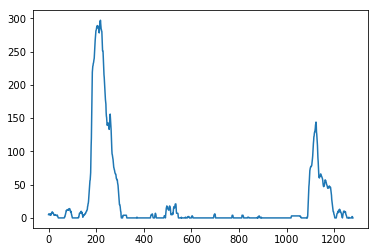

In [17]:
img = mpimg.imread('test_images/test5.jpg')
undist = UndistortImage(img)
warped, _ = WarpBinaryImg(undist)
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)


The following is function that do the sliding windows to fit the actual line onto the laneline in the image. I have defined the number of sliding windows as 9. The following code is simply almost identical to the sample code from the class material.

In [18]:
def draw_and_fit_lines(img, plot = False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    warped = img.copy()
    histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
                      (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
                      (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                          (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if plot == True:   
        ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fit, right_fit, out_img


The following is the output of line fit onto the warped images.

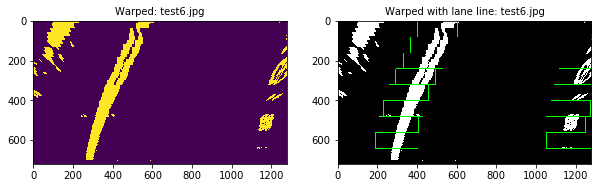

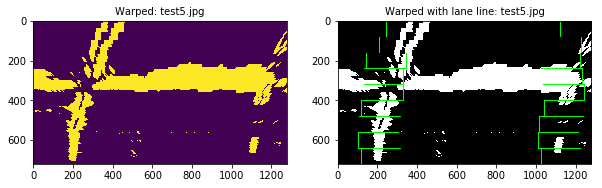

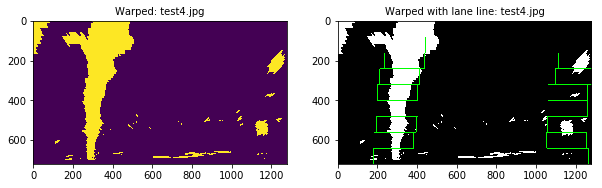

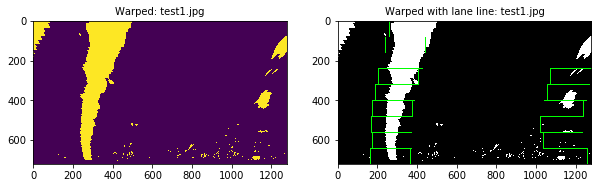

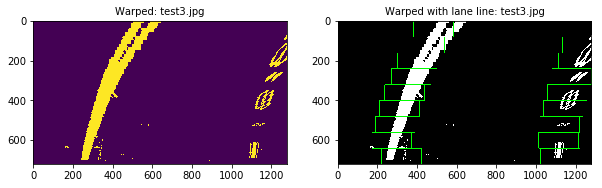

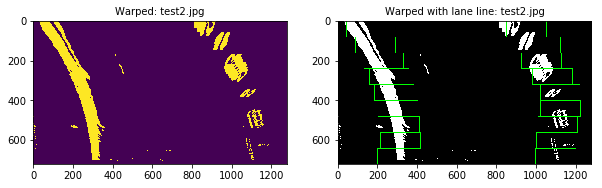

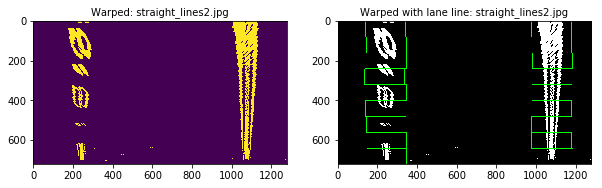

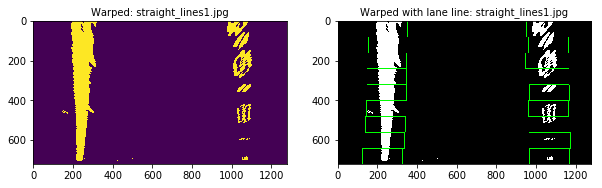

In [19]:
images = glob.glob('test_images/*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    undist = UndistortImage(img)
    warped, _ = WarpBinaryImg(undist)
    left_fit, right_fit, out_img = draw_and_fit_lines(warped)

    filename = ntpath.basename(fname)

    CompareImage(warped, out_img, 'Warped: '+filename, 'Warped with lane line: '+filename)

In [20]:
def draw_and_fit_lines_Cont(warped, left_fit, right_fit, plot = True):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit_re = [] if len(leftx) == 0 else np.polyfit(lefty, leftx, 2)
    right_fit_re = [] if len(rightx) == 0 else np.polyfit(righty, righty, 2)
    
    if plot == True:
    
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
   
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        
    return left_fit_re, right_fit_re


The following is the curvature function that basically calculate the curve of the lane

In [21]:
def curvature(left_fit, right_fit, binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    #Define left and right lanes in pixels
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #Identify new coefficients in metres
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #Calculation of center
    #left_lane and right lane bottom in pixels
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    # Lane center as mid of left and right lane bottom
                            
    lane_center = (left_lane_bottom + right_lane_bottom)/2.
    center_image = 640
    center = (lane_center - center_image)*xm_per_pix #Convert to meters
    
    return left_curverad, right_curverad, center


In [22]:
left_fit, right_fit, out_img = draw_and_fit_lines(warped)
left, right, center = curvature(left_fit, right_fit, out_img)
print(left, right, center)

4721.66206421 900.515251952 -0.0130788569344


This funciton just draw the line from the output of curvature and then unwarp the image back to original. It is almost identical to the original code from the class material.

In [23]:
def draw_lines(undist, warped, left_fit, right_fit, left_cur, right_cur, center, M, show_img = True ):

    def add_text_to_image(img, left_cur, right_cur, center):
        cur = (left_cur + right_cur)/2.
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, 'Radius of Curvature = %d(m)' % cur, (50, 50), font, 1, (255, 255, 255), 2)
        left_or_right = "left" if center < 0 else "right"
        cv2.putText(img, 'Vehicle is %.2fm %s of center' % (np.abs(center), left_or_right), (50, 100), 
                    font, 1, (255, 255, 255), 2)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    # Fit new polynomials to x,y in world space
    left_fitx = left_fit[0]*ploty**2+left_fit[1]*ploty+left_fit[2]
    right_fitx = right_fit[0]*ploty**2+right_fit[1]*ploty+right_fit[2] 

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
#    M = cv2.getPerspectiveTransform(src_p, dst_p)
    newwarp = cv2.warpPerspective(color_warp, M, (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    add_text_to_image(result, left_cur, right_cur, center)
    if show_img == True:
        plt.figure(figsize=(10,10))
        fig = plt.figure()
        plt.imshow(result)
    
    return result

Putting everyhing together, I create a function call DetectLaneOnRoad that do all of the above and draw the lane line back to the image. The following contains how the output look like.

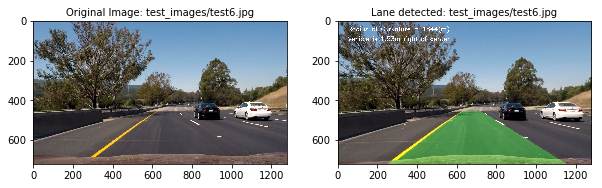

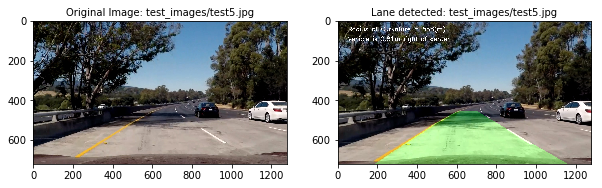

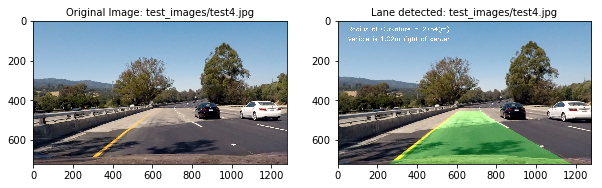

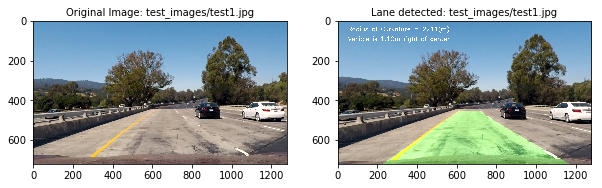

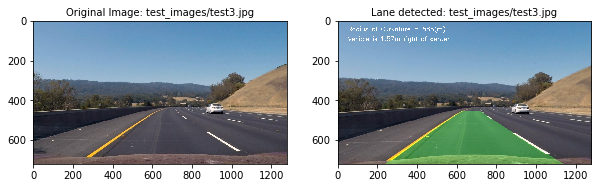

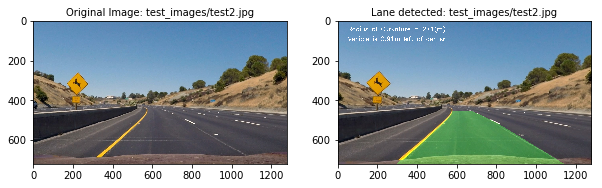

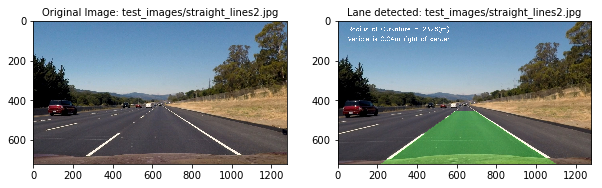

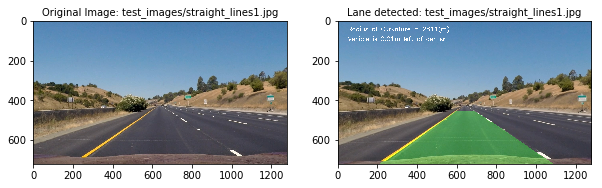

In [32]:
def DetectLaneOnRoad(img):
    img = UndistortImage(img)
    warped, M = WarpBinaryImg(img)
    left_fit, right_fit, out_img = draw_and_fit_lines(warped)
    left, right, center = curvature(left_fit, right_fit, warped)
    return draw_lines(img, warped, left_fit, right_fit, left, right, center, M, show_img = False)


images = glob.glob('test_images/*.jpg')
for fname in images:
    img = mpimg.imread(fname)
    dst = DetectLaneOnRoad(img)
    filename = ntpath.basename(fname)
    im = Image.fromarray(dst)
    im.save("output_images/LaneDetected_" + filename)
    CompareImage(img, dst, 'Original Image: '+fname, 'Lane detected: '+fname)

In [25]:
def sanity_check(left_fit, right_fit):
    if len(left_fit) ==0 or len(right_fit) == 0:
        return False
    else:
        #Check distance b/w lines
        ploty = np.linspace(0, 20, num=10 )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        delta_lines = np.mean(right_fitx - left_fitx)
        if delta_lines < 150 or delta_lines > 450:
            return False

        # Calculate slope of left and right lanes at midpoint of y (i.e. 360)
        L_0 = 2*left_fit[0]*360+left_fit[1]
        R_0 = 2*right_fit[0]*360+right_fit[1]
        delta_slope_mid =  np.abs(L_0-R_0)
        
        #Check if lines are parallel at the middle
        
        if delta_slope_mid<=0.1:
            status = True
        else:
            status = False
            
    return status

In [26]:
# Import everything needed to edit/save/watch video clips
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [30]:
def process_image2(img):
    return DetectLaneOnRoad(img)

def process_image(img):
    global counter1
    global last_left1
    global last_right1
    global left_fit1
    global right_fit1

    img = UndistortImage(img)
    warped, M = WarpBinaryImg(img)
    
    if counter1 == 0:
        left_fit1, right_fit1, out_img = draw_and_fit_lines(warped)
    else:
        left_fit1, right_fit1  = draw_and_fit_lines_Cont(warped, left_fit1, right_fit1, plot = False)

    #Decide if to use calculated points
    if sanity_check(left_fit, right_fit):        
        #Save as last reliable fit
        last_left1, last_right1 = left_fit1, right_fit1        
        counter1+=1
    else:        #Use the last realible fit
        left_fit1, right_fit1 = last_left1, last_right1        
        
    left, right, center = curvature(left_fit1, right_fit1, warped)
    return draw_lines(img, warped, left_fit1, right_fit1, left, right, center, M, show_img = False)

In [31]:
counter1 = 0

if not os.path.exists("test_videos_output"):
    os.makedirs("test_videos_output")
    
white_output = 'test_videos_output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

NameError: name 'last_left1' is not defined

In [29]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))